In [101]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Test Specific Libraries
from sklearn.decomposition import PCA, FastICA
import cell2sentence as cs
from cell2sentence import tasks, CSData, CSModel
from cell2sentence.prompt_formatter import PromptFormatter
import ot
import cinemaot as co

# Huggingface
import torch
from transformers import AutoModelForCausalLM
from datasets import load_from_disk

# Confusion Matrix visualization
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

In [102]:
import ot

In [103]:
# load processed AnnData objects for human and mouse cells
human_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/human_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")
mouse_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/mouse_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")

In [104]:
human_restricted

AnnData object with n_obs × n_vars = 8569 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [105]:
human_restricted.X.data[:10]  # Already preprocessed, no need to filter/normalize

array([0.08864673, 0.08864673, 0.16223046, 0.22513437, 0.08864673,
       0.2800693 , 0.16223046, 0.08864673, 0.16223046, 0.32882914],
      dtype=float32)

In [106]:
mouse_restricted

AnnData object with n_obs × n_vars = 1886 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [107]:
human_restricted.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0


In [108]:
# Ensure organism key is present for both human and mouse
if 'organism' not in human_restricted.obs:
    human_restricted.obs['organism'] = 'Homo sapiens'
if 'organism' not in mouse_restricted.obs:
    mouse_restricted.obs['organism'] = 'Mus musculus'

# Ensure cell_tyope key is present - slightly misworded
if 'cell_type' not in human_restricted.obs:
    human_restricted.obs['cell_type'] = human_restricted.obs['cell_types']
if 'cell_type' not in mouse_restricted.obs:
    mouse_restricted.obs['cell_type'] = mouse_restricted.obs['cell_types']

human_restricted.obs['cell_type'] = [x.lower() for x in human_restricted.obs['cell_type']]
mouse_restricted.obs['cell_type'] = [x.lower() for x in mouse_restricted.obs['cell_type']]

# Add species labels
human_restricted.obs['species'] = 'human'
mouse_restricted.obs['species'] = 'mouse'

In [109]:
human_restricted.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,organism,cell_type,species
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0,Homo sapiens,acinar,human
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0,Homo sapiens,acinar,human


In [110]:
c2s_save_dir = "/home/dor3/scratch/C2S_Files/c2s_api_testing"  # C2S dataset will be saved into this directory
human_c2s_save_name = "human_pancreas_tissue_c2s_embeddings_cinema_ot"  # This will be the name of our C2S dataset on disk
mouse_c2s_save_name = "mouse_pancreas_tissue_c2s_embeddings_cinema_ot"  # This will be the name of our C2S dataset on disk

In [111]:
# arrow_dir='./data/'
# # ensure the directory for Arrow datasets exists
# os.makedirs(arrow_dir, exist_ok=True)

# # paths to Arrow datasets
# arrow_path_human = os.path.join(arrow_dir, 'human_arrow')
# arrow_path_mouse = os.path.join(arrow_dir, 'mouse_arrow')

# convert AnnData to Arrow format and save
'''# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)'''
human_arrow_ds, human_vocab = CSData.adata_to_arrow(
    adata=human_restricted, 
    random_state=1234, 
    sentence_delimiter=' ',
    label_col_names=['cell_type', 'organism']  # NOTE: need this to keep 'organism' column in arrow dataset!
)

mouse_arrow_ds, mouse_vocab = CSData.adata_to_arrow(
    adata=mouse_restricted,
    random_state=1234, 
    sentence_delimiter=' ',
    label_col_names=['cell_type', 'organism']  # NOTE: need this to keep 'organism' column in arrow dataset!
)

WARN: more variables (12113) than observations (8569)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (12113) than observations (8569), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 8569/8569 [00:03<00:00, 2317.68it/s]
WARN: more variables (12113) than observations (1886)... did you mean to transpose the object (e.g. adata.T)?
WARN: more variables (12113) than observations (1886), did you mean to transpose the object (e.g. adata.T)?
100%|██████████| 1886/1886 [00:00<00:00, 2498.92it/s]


In [112]:
human_arrow_ds  # NOTE: notice how 'organism' shows up now in the columns

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 8569
})

In [113]:
mouse_arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 1886
})

In [114]:
human_csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=human_arrow_ds, 
    vocabulary=human_vocab,
    save_dir=c2s_save_dir,
    save_name=human_c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (0/1 shards):   0%|          | 0/8569 [00:00<?, ? examples/s]

In [115]:
mouse_csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=mouse_arrow_ds, 
    vocabulary=mouse_vocab,
    save_dir=c2s_save_dir,
    save_name=mouse_c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (0/1 shards):   0%|          | 0/1886 [00:00<?, ? examples/s]

In [116]:
# Define CSModel object
# Huggingface link: https://huggingface.co/vandijklab/C2S-Pythia-410m-diverse-single-and-multi-cell-tasks

# Pull model from web, save model to disk
model_path = "vandijklab/C2S-Pythia-410m-diverse-single-and-multi-cell-tasks"
save_dir = "/home/dor3/palmer_scratch/C2S_Files_Daphne/c2s_api_testing/csmodel_tutorial_2"
save_name = "cell_embedding_prediction_pythia_410M_1"
csmodel = cs.CSModel(
    model_name_or_path=model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


In [117]:
# Identify parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Define the directory to save the embeddings
embedded_cells_dir = os.path.join(parent_dir, "Embedded Cells")
os.makedirs(embedded_cells_dir, exist_ok=True)

# Define file paths for human and mouse embeddings
human_embedding_path = os.path.join(embedded_cells_dir, "human_embeddings.npy")
mouse_embedding_path = os.path.join(embedded_cells_dir, "mouse_embeddings.npy")

# Function to save embeddings
def save_embeddings(embedding, filepath):
    np.save(filepath, embedding)
    print(f"Saved embeddings to {filepath}")

# Function to load embeddings
def load_embeddings(filepath):
    embedding = np.load(filepath)
    print(f"Loaded embeddings from {filepath}")
    return embedding


In [118]:
# Check if embeddings already exist
if os.path.exists(human_embedding_path): 
    # Load the embeddings from files
    embedded_human_cells = load_embeddings(human_embedding_path)

else:
    # Perform embedding using the GPU (with Cell2Sentence)
    # Embed human cells
    embedded_human_cells = tasks.embed_cells(
        csdata=human_csdata,
        csmodel=csmodel,
        n_genes=1000,
        inference_batch_size=1
    )
    # Save the embeddings to files so we don't need to use GPU next time
    save_embeddings(embedded_human_cells, human_embedding_path)

if os.path.exists(mouse_embedding_path):
    # Load the embeddings from files
    embedded_mouse_cells = load_embeddings(mouse_embedding_path)
else:
    # Perform embedding using the GPU (with Cell2Sentence)
    # Embed mouse cells
    embedded_mouse_cells = tasks.embed_cells(
        csdata=mouse_csdata,
        csmodel=csmodel,
        n_genes=1000,
        inference_batch_size=1
    )
    # Save the embeddings to files so we don't need to use GPU next time
    save_embeddings(embedded_mouse_cells, mouse_embedding_path)

Loaded embeddings from /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Embedded Cells/human_embeddings.npy
Loaded embeddings from /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Embedded Cells/mouse_embeddings.npy


In [119]:
human_c2s_embed_matrix = embedded_human_cells  # This should be shape [num_cells, num_genes]
# Define an observation dataframe
obs_df = human_restricted.obs.copy()  # Just copy obs df from original anndata object, since cells are the same

# Define a variables dataframe
col_names = ["dim_{}".format(idx) for idx in range(human_c2s_embed_matrix.shape[1])]
var_df = pd.DataFrame({
    "col_names": col_names
}, index=col_names)

# Define AnnData object with C2S embeddings
human_adata = anndata.AnnData(X=human_c2s_embed_matrix, obs=obs_df, var=var_df)

In [120]:
mouse_c2s_embed_matrix = embedded_mouse_cells  # This should be shape [num_cells, num_genes]
# Define an observation dataframe
obs_df = mouse_restricted.obs.copy()  # Just copy obs df from original anndata object, since cells are the same

# Define a variables dataframe
col_names = ["dim_{}".format(idx) for idx in range(mouse_c2s_embed_matrix.shape[1])]
var_df = pd.DataFrame({
    "col_names": col_names
}, index=col_names)

# Define AnnData object with C2S embeddings
mouse_adata = anndata.AnnData(X=mouse_c2s_embed_matrix, obs=obs_df, var=var_df)

In [121]:
def optimal_transport_pairing(adata_human, adata_mouse):
    """
    Compute the optimal transport (OT) pairing between human and mouse cells.

    Parameters:
    - adata_human: AnnData object for human cells.
    - adata_mouse: AnnData object for mouse cells.

    Returns:
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    """
    # Extract the gene expression matrices
    X_human = adata_human.X
    X_mouse = adata_mouse.X
    
    # Compute the cost matrix using Euclidean distance
    cost_matrix = ot.dist(X_human, X_mouse, metric='euclidean')

    # Visualize the cost matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cost_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Euclidean Distance')
    plt.title('Cost Matrix (Euclidean Distance)')
    plt.xlabel('Mouse Cells')
    plt.ylabel('Human Cells')
    plt.show()
    
    # Uniform distribution over human and mouse cells
    human_distribution = np.ones(X_human.shape[0]) / X_human.shape[0]
    mouse_distribution = np.ones(X_mouse.shape[0]) / X_mouse.shape[0]
    
    # Compute the optimal transport matrix using the Earth Mover's Distance
    ot_matrix = ot.emd(human_distribution, mouse_distribution, cost_matrix)
    
    # Find the optimal pairs based on the transport plan
    paired_indices = []
    for human_idx in range(ot_matrix.shape[0]):
        mouse_idx = np.argmax(ot_matrix[human_idx])
        paired_indices.append((human_idx, mouse_idx))
    
    return paired_indices, ot_matrix

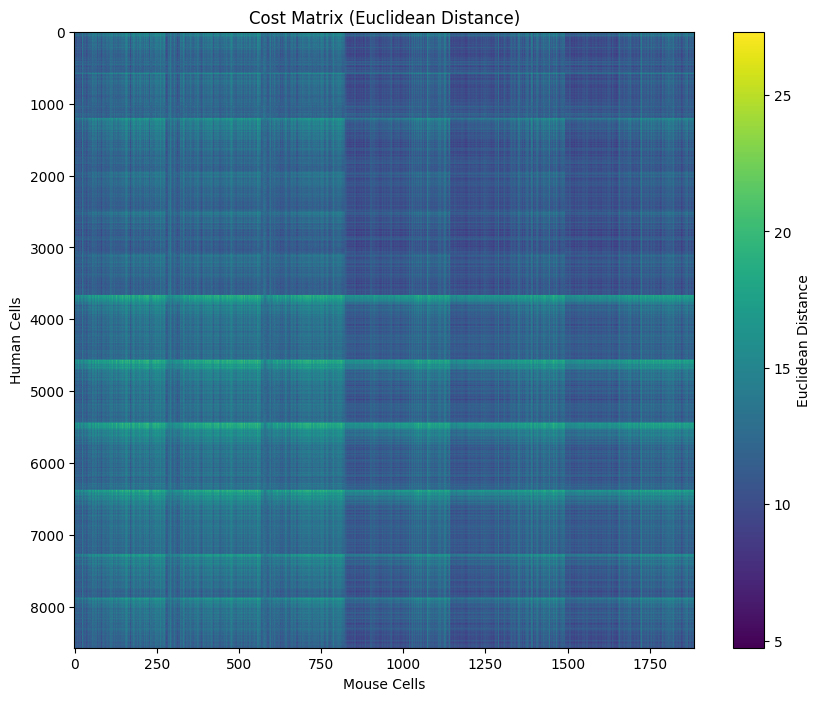

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.


8569

In [122]:
paired_indices, ot_matrix = optimal_transport_pairing(human_adata, mouse_adata)
len(paired_indices)

In [123]:
print(paired_indices[0])
print(paired_indices[1])
print(paired_indices[2])

(0, 0)
(1, 0)
(2, 0)


In [124]:
# Is the default 0? What happens in this OT method that makes so many of them match to 0?
print(paired_indices[:50])

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 569), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 1385), (13, 1227), (14, 1541), (15, 3), (16, 1010), (17, 0), (18, 292), (19, 1011), (20, 951), (21, 1834), (22, 575), (23, 1492), (24, 1304), (25, 1556), (26, 837), (27, 364), (28, 1859), (29, 1521), (30, 1403), (31, 885), (32, 1615), (33, 921), (34, 1591), (35, 0), (36, 21), (37, 1674), (38, 960), (39, 909), (40, 1393), (41, 1246), (42, 1320), (43, 1393), (44, 1555), (45, 1113), (46, 0), (47, 573), (48, 410), (49, 924)]


In [125]:
# Combine the datasets to perform OT
combined_adata = anndata.concat([human_adata, mouse_adata], merge='same')

# Ensure UMAP is computed and stored in the AnnData object
if 'X_umap' not in combined_adata.obsm:
    sc.pp.neighbors(combined_adata)
    sc.tl.umap(combined_adata)


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [126]:
# Create the "plots" directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


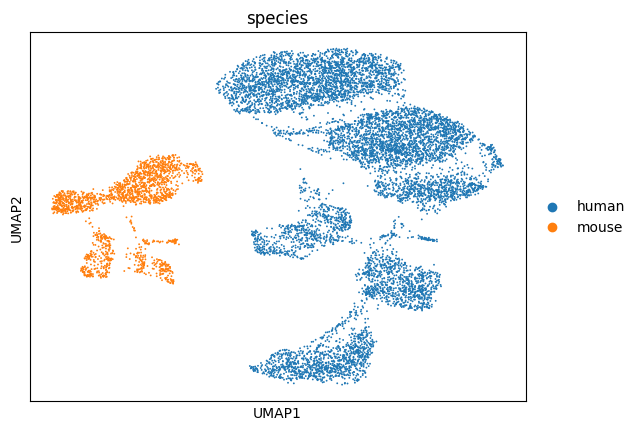

UMAP plot saved to plots/umap_cell_embeddings_colored_by_species.png


In [127]:
# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)

# Visualize UMAP
umap_species_plot_path = os.path.join(plots_dir, "umap_cell_embeddings_colored_by_species.png")
fig = sc.pl.umap(combined_adata, color=['species'], return_fig=True, s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_species_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_species_plot_path}")


/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


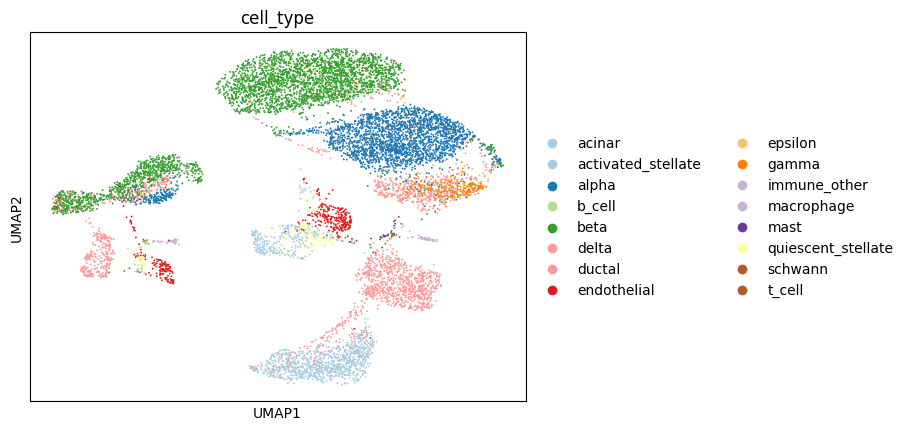

UMAP plot saved to plots/umap_cell_embeddings_colored_by_cell_type.png


In [136]:
# Optional: Visualize the optimal transport pairs on UMAP
sc.pp.neighbors(combined_adata, use_rep='X_pca')
sc.tl.umap(combined_adata)

# Visualize UMAP
umap_cell_type_plot_path = os.path.join(plots_dir, "umap_cell_embeddings_colored_by_cell_type.png")
cmap = plt.get_cmap('magma')
fig = sc.pl.umap(combined_adata, color=['cell_type'], return_fig=True, palette="Paired", s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_cell_type_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_cell_type_plot_path}")

# Plot classic OT pairs on a umap, showing cell_type and species plots.

In [148]:
def plot_joint_umap_with_pairs(
    human_mouse_joint_adata,
    num_human_cells,
    paired_indices,
    color_label,
    save_path,
    title,
    cell_type=None,
    adata_human=None,
    adata_mouse=None,
    filter_by_human=True  # if True, shows which mouse cells all human cells map to, else vice versa
):
    """
    Create a joint UMAP of human and mouse AnnData objects and plot the lines connecting paired cells.

    Parameters:
    - human_mouse_adata: AnnData object for human and mouse cells.
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    - color_label: The column in `obs` to color by.
    - save_path: Path to save the plot.
    - cell_type: (Optional) Filter pairs by specific cell type.
    - adata_human: AnnData object for human cells.
    - adata_mouse: AnnData object for mouse cells.
    - filter_by_human: True to filter by human cell type, False to filter by mouse cell type.
    """
    # Ensure the "plots" directory exists
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    # Construct the full save path
    full_save_path = os.path.join(plots_dir, save_path)
    
    # Ensure UMAP is computed and stored in the AnnData object
    if 'X_umap' not in human_mouse_joint_adata.obsm:
        sc.pp.neighbors(human_mouse_joint_adata)
        sc.tl.umap(human_mouse_joint_adata)
    
    if color_label=='species':
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            s=7,
            title=title,
        )
    else:
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            palette="Paired",
            s=7,
            title=title,
        )

    # Extract the UMAP coordinates
    umap_human = human_mouse_joint_adata.obsm['X_umap'][:num_human_cells, :]
    umap_mouse = human_mouse_joint_adata.obsm['X_umap'][num_human_cells:, :]

    # Filter the paired indices based on the specified cell type, if provided
    if cell_type:
        if filter_by_human:
            human_cell_type_mask = adata_human.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if human_cell_type_mask[human_idx]
            ]
        else:
            mouse_cell_type_mask = adata_mouse.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if mouse_cell_type_mask[mouse_idx]
            ]
    else:
        # Use all pairs if no cell type is specified
        filtered_pairs = paired_indices

    # Plot lines connecting paired human and mouse cells
    for human_idx, mouse_idx in filtered_pairs:
        # Get the UMAP coordinates of the paired human and mouse cells
        human_coord = umap_human[human_idx]
        mouse_coord = umap_mouse[mouse_idx]
        
        # Plot a light gray line connecting the paired cells
        plt.plot([human_coord[0], mouse_coord[0]], 
                 [human_coord[1], mouse_coord[1]], 
                 color='lightgray', linewidth=0.6, alpha=0.2, linestyle="--")

    # Save the plot
    plt.savefig(full_save_path, facecolor="white", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    # Print confirmation
    print(f"Plot saved to {full_save_path}")

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


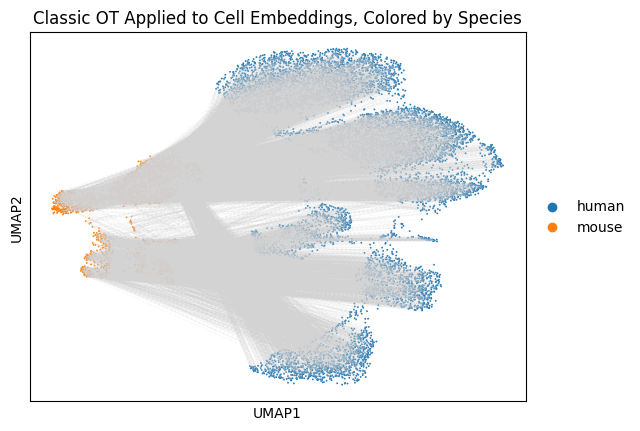

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Classic OT on Cell Embeddings/plots/classic_ot_paired_cell_embeddings_species.png


In [151]:
color_label='species'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_adata.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="classic_ot_paired_cell_embeddings_species.png", 
    title=f"Classic OT Applied to Cell Embeddings, Colored by {str.capitalize(color_label)}",
    adata_human=human_adata, 
    adata_mouse=mouse_adata
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


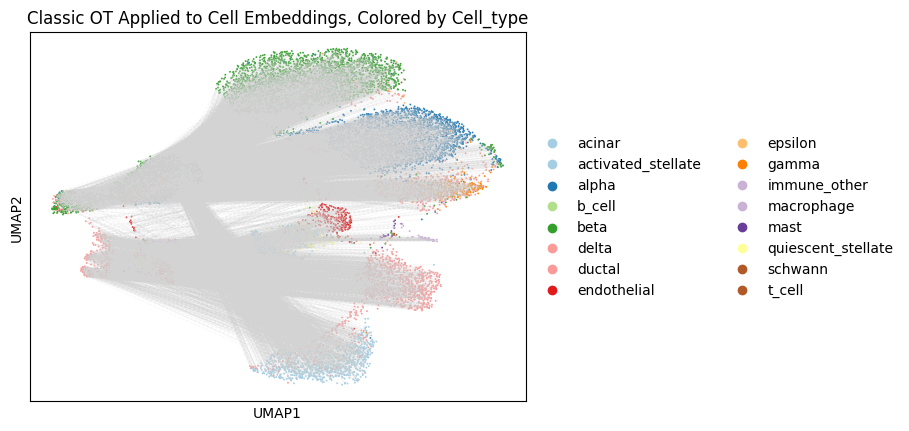

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Classic OT on Cell Embeddings/plots/classic_ot_paired_cell_embeddings_cell_type.png


In [152]:
color_label='cell_type'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_adata.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="classic_ot_paired_cell_embeddings_cell_type.png", 
    title=f"Classic OT Applied to Cell Embeddings, Colored by {str.capitalize(color_label)}",
    adata_human=human_adata, 
    adata_mouse=mouse_adata
)

In [153]:
# Extract true labels
human_labels = [x.lower() for x in human_restricted.obs['cell_type'].values]
mouse_labels = [x.lower() for x in mouse_restricted.obs['cell_type'].values]

# Create lists of labels based on paired indices
paired_human_labels = [human_labels[p[0]] for p in paired_indices]
paired_mouse_labels = [mouse_labels[p[1]] for p in paired_indices]

# Ensure both label sets are consistent but separated by species
unique_human_labels = np.unique(human_labels)
unique_mouse_labels = np.unique(mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Combine unique labels for human and mouse separately
all_labels = np.union1d(unique_human_labels, unique_mouse_labels)

Unique human labels: ['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'gamma' 'immune_other' 'macrophage' 'quiescent_stellate'
 'schwann' 't_cell']


In [142]:
same_cell_type = [x for x in all_labels if x in unique_human_labels and x in unique_mouse_labels]
print("Shared cell types in human and mice:", same_cell_type)

Shared cell types in human and mice: ['activated_stellate', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'gamma', 'macrophage', 'quiescent_stellate', 'schwann', 't_cell']


In [143]:
plot_path = "classic_ot_embedded_cells_confusion_matrix"
# Generate confusion matrix with consistent labels
cm = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df = DataFrame(cm, index=all_labels, columns=all_labels)

# Compute row and column sums
row_sums = cm_df.sum(axis=1)
col_sums = cm_df.sum(axis=0)

# Filter rows and columns where the sum of values is not equal to 0
non_zero_rows = row_sums != 0
non_zero_cols = col_sums != 0

# Apply the filters to the DataFrame
filtered_cm_df = cm_df.loc[non_zero_rows, non_zero_cols]

# Define file path for the heatmap plot
cm_path = os.path.join(plots_dir, plot_path)

# Create a matplotlib figure and axis
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_cm_df, annot=True, fmt='d', cmap='Greens', linewidths=.4)
plt.title('Confusion Matrix of Human-Mouse Cell Pairs', fontsize=20)
plt.xlabel('Mouse Cell Types', fontsize=15)
plt.ylabel('Human Cell Types', fontsize=15)

# Save the plot using matplotlib
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Confusion matrix plot saved to {cm_path}")


Confusion matrix plot saved to plots/classic_ot_embedded_cells_confusion_matrix


In [144]:
'''
Color Rankings: 
1. Paired
2. Greens
2. YlGn
2. 

'''

'\nColor Rankings: \n1. Paired\n2. Greens\n2. YlGn\n2. \n\n'